# US Hurricane Catastrophe Model

A very simple model of US hurricane exposure parameterized to observed event frequency 1851-2017 and a smattering of losses 1970-2017.

* Frequency: Poisson(1.74)
* Severity: lognormal($\mu=19.595, \sigma=2.581$)

## Model Algorithm I 

    for year = 1 to N
        simulate number of events E from Poisson(1.74)
        for event_num = 1 to E
            simulate loss L from Lognormal(mu, sigma)
            store year, event_num, L

## Model Algorithm II 

This method is more suited to a spreadsheet implementation. 

    time = 0
    event_id = 0
    last_year = 0
    for event = 1 to N
        simulate waiting time for event t from Exponential(1.74)
        time = time + t
        year = integer part of time
        if year > last_year then event_id = 0, last_year = year
        simulate loss L from Lognormal(mu, sigma)
        store year, event_id, L
        event_id = event_id + 1


In [18]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set(context='paper', style='darkgrid', font='sans')

## Claim Count Component

Based on an analysis of landfalling hurricanes since 1851 we selected a Poisson(1.74) to model the number of hurricanes making landfall in the Continental US each year. 

The next few commands create a variable to represent this random variable. 

In [15]:
freq = 290 / 167
poi = ss.poisson(freq)

In [16]:
# simulate 10 random draws
poi.rvs(10)

array([3, 1, 0, 2, 2, 0, 1, 3, 2, 1])

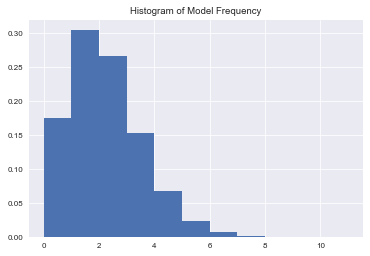

In [20]:
# generate 100,000 draws and creates a histogram
N = 100000
temp = poi.rvs(N)
plt.hist(temp, bins=np.arange(12), density=True)
plt.title('Histogram of Model Frequency');

In [21]:
# can compute frequencies by hand 
unq = np.unique(temp, return_counts=True)
unq

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([17479, 30447, 26677, 15346,  6791,  2312,   707,   186,    44,
           11], dtype=int64))

In [36]:
# can compare with actual 
model = [np.exp(-freq)]
for i in range(1,len(unq[0])):
    model.append(model[i-1] * freq / i)
model = np.array(model)

In [38]:
# compare with freqs
print('    N Simulation           Model         Error')
for i, s, m in zip(unq[0], unq[1], N*model):
    print(f'{i:5d}\t{s:8,d}\t{m:8,.1f}\t{s/m-1:6.3f}')


    N Simulation           Model         Error
    0	  17,479	17,613.1	-0.008
    1	  30,447	30,585.6	-0.005
    2	  26,677	26,556.4	 0.005
    3	  15,346	15,372.0	-0.002
    4	   6,791	 6,673.5	 0.018
    5	   2,312	 2,317.7	-0.002
    6	     707	   670.8	 0.054
    7	     186	   166.4	 0.118
    8	      44	    36.1	 0.218
    9	      11	     7.0	 0.578


In [39]:
# or the same thing using pandas
df = pd.DataFrame(dict(N=unq[0], Simulation=unq[1]/N, Model=model))
df['Error'] = df.Simulation / df.Model - 1
df = df.set_index("N")
df.index.name="N"
df

,Simulation,Model,Error
N,,,
0,0.17479,0.176131,-0.007614
1,0.30447,0.305856,-0.004533
2,0.26677,0.265564,0.004542
3,0.15346,0.153720,-0.001689
4,0.06791,0.066735,0.017614
5,0.02312,0.023177,-0.002471
6,0.00707,0.006708,0.053967
7,0.00186,0.001664,0.117730
8,0.00044,0.000361,0.218106


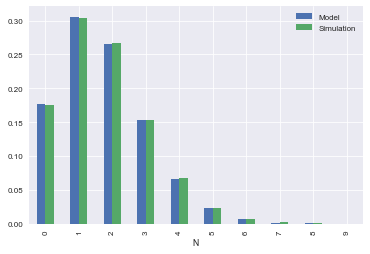

In [40]:
df[['Model', 'Simulation']].plot(kind='bar')

## Severity Component

Lognormal(mu, sigma)


In [41]:
mu = 19.595
sigma = 2.581

In [42]:
# variable to simulate lognormals
ln = ss.lognorm(sigma, scale=np.exp(mu))

In [43]:
# mean and variance
ln.stats('mv')

(array(9.04773693e+09), array(6.39150642e+22))

In [44]:
sample = ln.rvs(N)

In [45]:
# compare sample mean with known mean of lognormal
np.array((sample.mean(), np.exp(mu + sigma**2 / 2), ln.stats('m'))) / 1e9

array([8.27616927, 9.04773693, 9.04773693])

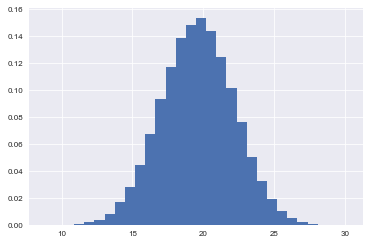

In [46]:
# histogram of log losses 
plt.hist(np.log(sample), density=True, bins=30);

((array([-4.34602155, -4.14724578, -4.03913009, ...,  4.03913009,
          4.14724578,  4.34602155]),
  array([ 8.7366026 ,  8.954153  ,  9.34696193, ..., 29.86270142,
         29.98499209, 30.22495251])),
 (2.583064883002095, 19.590804896367704, 0.9999908845078628))

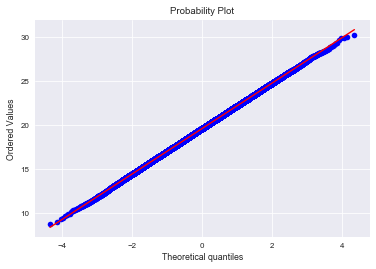

In [47]:
# probability plot = perfect
ss.probplot(np.log(sample), plot=plt)

# Aggregate Losses

## Model Algorithm I 

    for year = 1 to N
        simulate number of events E from Poisson(1.74)
        for event_num = 1 to E
            simulate loss L from Lognormal(mu, sigma)
            store year, event_num, L

In [48]:
# setup  variables 
# N = number of simulation years
N = 100000
freq = 290 / 167
freq_dist = ss.poisson(freq)
mu = 19.595
sigma = 2.581
sev_dist = ss.lognorm(sigma, scale=np.exp(mu))

In [49]:
# simulate annual event founds 
event_counts = freq_dist.rvs(N)
num_events = event_counts.sum()
num_events, N * freq

(173271, 173652.69461077845)

## ELT and YLT

Event Loss Table, ELT, will have columns

* Event ID
* Simulated Year
* Event Loss

Yearly Loss Table, YLT, will have columns 

* Year
* Event count, the number of events in the year
* Sum = total loss in the year (for Agg PMLs)
* Max = largest loss in the year (for occ PMLs)

In [50]:
# container for YLT
ylt = np.zeros((N, 4))

In [51]:
# fill in year ID and event count, arrays are 0 based
ylt[:, 0] = np.arange(N)
ylt[:, 1] = event_counts

In [52]:
# look at the top ten rows (:10) and all columns (:)
ylt[:10,:]

array([[0., 3., 0., 0.],
       [1., 0., 0., 0.],
       [2., 2., 0., 0.],
       [3., 4., 0., 0.],
       [4., 2., 0., 0.],
       [5., 3., 0., 0.],
       [6., 2., 0., 0.],
       [7., 0., 0., 0.],
       [8., 3., 0., 0.],
       [9., 3., 0., 0.]])

In [53]:
# container for ELT, now we know number of rows - sum of num events from YLT
elt = np.zeros((num_events, 3))
# add event ID, counter 0, 1, ...
elt[:, 0] = np.arange(num_events)

In [54]:
# how big is ylt: should be freq x N rows, can use shape or len:
elt.shape,  len(elt), freq * N, freq, num_events, N

((173271, 3), 173271, 173652.69461077845, 1.7365269461077844, 173271, 100000)

In [55]:
# simulate individual event losses
elt[:, 2] = sev_dist.rvs(num_events)

In [56]:
# look at answer
elt[:10, :]

array([[0.00000000e+00, 0.00000000e+00, 4.90312025e+08],
       [1.00000000e+00, 0.00000000e+00, 1.98054412e+10],
       [2.00000000e+00, 0.00000000e+00, 3.70007018e+07],
       [3.00000000e+00, 0.00000000e+00, 7.26591831e+07],
       [4.00000000e+00, 0.00000000e+00, 2.48869009e+10],
       [5.00000000e+00, 0.00000000e+00, 2.27705412e+07],
       [6.00000000e+00, 0.00000000e+00, 5.05163746e+07],
       [7.00000000e+00, 0.00000000e+00, 7.38380853e+07],
       [8.00000000e+00, 0.00000000e+00, 5.35563404e+09],
       [9.00000000e+00, 0.00000000e+00, 3.93118664e+08]])

In [ ]:
# tricky part...need to fill in the event years in the YLT
# make an array showing starting and ending number of events for each year
event_boundaries = event_counts.cumsum()
# start at zero
event_boundaries = np.hstack((0, event_boundaries))

In [ ]:
ylt[:10, 1], event_boundaries[:10]

(array([5., 1., 0., 1., 1., 1., 3., 0., 2., 1.]),
 array([ 0,  5,  6,  6,  7,  8,  9, 12, 12, 14]))

In [ ]:
# non pythonic 
# %%timeit
for i in range(N):
    if event_boundaries[i] < event_boundaries[i+1]:
        elt[event_boundaries[i]:event_boundaries[i+1], 1] = i

In [ ]:
# num events per year and the created year IDs
ylt[:10,1], elt[:10, :]

(array([5., 1., 0., 1., 1., 1., 3., 0., 2., 1.]),
 array([[0.00000000e+00, 0.00000000e+00, 3.80516126e+08],
        [1.00000000e+00, 0.00000000e+00, 8.51402423e+07],
        [2.00000000e+00, 0.00000000e+00, 1.62254771e+09],
        [3.00000000e+00, 0.00000000e+00, 3.57940987e+10],
        [4.00000000e+00, 0.00000000e+00, 3.24507687e+08],
        [5.00000000e+00, 1.00000000e+00, 7.74423221e+09],
        [6.00000000e+00, 3.00000000e+00, 9.51692448e+09],
        [7.00000000e+00, 4.00000000e+00, 1.28294746e+07],
        [8.00000000e+00, 5.00000000e+00, 1.45585602e+07],
        [9.00000000e+00, 6.00000000e+00, 8.06740030e+07]]))

In [ ]:
# maybe more pythonic
# %%timeit
for i, (b, e) in enumerate(zip(event_boundaries[:-1], event_boundaries[1:])):
    if e > b:
        elt[b:e, 1] = i

In [ ]:
# top 10 rows of ylt and elt
ylt[:10, :], elt[:10, :]

(array([[0., 5., 0., 0.],
        [1., 1., 0., 0.],
        [2., 0., 0., 0.],
        [3., 1., 0., 0.],
        [4., 1., 0., 0.],
        [5., 1., 0., 0.],
        [6., 3., 0., 0.],
        [7., 0., 0., 0.],
        [8., 2., 0., 0.],
        [9., 1., 0., 0.]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.80516126e+08],
        [1.00000000e+00, 0.00000000e+00, 8.51402423e+07],
        [2.00000000e+00, 0.00000000e+00, 1.62254771e+09],
        [3.00000000e+00, 0.00000000e+00, 3.57940987e+10],
        [4.00000000e+00, 0.00000000e+00, 3.24507687e+08],
        [5.00000000e+00, 1.00000000e+00, 7.74423221e+09],
        [6.00000000e+00, 3.00000000e+00, 9.51692448e+09],
        [7.00000000e+00, 4.00000000e+00, 1.28294746e+07],
        [8.00000000e+00, 5.00000000e+00, 1.45585602e+07],
        [9.00000000e+00, 6.00000000e+00, 8.06740030e+07]]))

In [ ]:
# combine: add losses to ELT and summarize back to the YLT, non pythonic
%%timeit
for i in range(N-1):
    if event_boundaries[i] < event_boundaries[i+1]:
        elt[event_boundaries[i]:event_boundaries[i+1], 1] = i
        ylt[i, 2] = elt[event_boundaries[i]:event_boundaries[i+1], 2].sum()
        ylt[i, 3] = elt[event_boundaries[i]:event_boundaries[i+1], 2].max()

1 loop, best of 3: 590 ms per loop


In [ ]:
# top 10 rows of ylt and elt
ylt[:10, :], elt[:10, :]

(array([[0.00000000e+00, 5.00000000e+00, 3.82068105e+10, 3.57940987e+10],
        [1.00000000e+00, 1.00000000e+00, 7.74423221e+09, 7.74423221e+09],
        [2.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [3.00000000e+00, 1.00000000e+00, 9.51692448e+09, 9.51692448e+09],
        [4.00000000e+00, 1.00000000e+00, 1.28294746e+07, 1.28294746e+07],
        [5.00000000e+00, 1.00000000e+00, 1.45585602e+07, 1.45585602e+07],
        [6.00000000e+00, 3.00000000e+00, 1.22982754e+09, 1.14896466e+09],
        [7.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
        [8.00000000e+00, 2.00000000e+00, 5.06273239e+08, 5.04389496e+08],
        [9.00000000e+00, 1.00000000e+00, 9.80374834e+08, 9.80374834e+08]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.80516126e+08],
        [1.00000000e+00, 0.00000000e+00, 8.51402423e+07],
        [2.00000000e+00, 0.00000000e+00, 1.62254771e+09],
        [3.00000000e+00, 0.00000000e+00, 3.57940987e+10],
        [4.00000000e+00, 0

In [ ]:
# combine: add losses to ELT and summarize back to the YLT, pythonic
%%timeit
for i, (b, e) in enumerate(zip(event_boundaries[:-1], event_boundaries[1:])):
    if e > b:
        elt[b:e, 1] = i
        ylt[i, 2] = elt[b:e, 2].sum()
        ylt[i, 3] = elt[b:e, 2].max()

In [ ]:
# top 10 rows of ylt and elt
ylt[:10, :], elt[:10, :]

### Use data types and name columns

In [ ]:
def simulate1(N, freq, mu, sigma):
    """
    Simulate ELT and YLT with N years, Poisson(freq) and lognormal(mu, sigma)
    severity
    
    """
    freq_dist = ss.poisson(freq)
    sev_dist = ss.lognorm(sigma, scale=np.exp(mu))

    # simulate events per year, figure number of events 
    event_counts = freq_dist.rvs(N)
    num_events = event_counts.sum()
    num_events, N * freq
    
    # make YLT
    ylt = np.zeros(N, dtype=[('year_id', 'int32'), ('num_events', 'int32'), 
                         ('sum_loss', 'float64'), 
                         ('max_loss', 'float64')])
    
    # fill in year ID and event count, arrays are 0 based
    ylt['year_id'] = np.arange(N)
    ylt['num_events'] = event_counts
    
    # container for ELT, now we know number of rows - sum of num events from YLT
    elt = np.zeros(num_events, dtype=[('event_id', 'int32'), ('year_id', 'int32'), 
                         ('loss', 'float64')])
    # add event ID, counter 0, 1, ...
    elt['event_id'] = np.arange(num_events)
    
    
    event_boundaries = event_counts.cumsum()
    event_boundaries = np.hstack((0, event_boundaries))
    elt['loss'] = sev_dist.rvs(num_events)
    
    # combine: add losses to ELT and summarize back to the YLT, non pythonic
    for i in range(N-1):
        if event_boundaries[i] < event_boundaries[i+1]:
            elt[event_boundaries[i]:event_boundaries[i+1]]['year_id'] = i
            ylt[i]['sum_loss'] = elt[event_boundaries[i]:event_boundaries[i+1]]['loss'].sum()
            ylt[i]['max_loss'] = elt[event_boundaries[i]:event_boundaries[i+1]]['loss'].max()
            
    # sort YLT by loss 
    ylt.sort(order='sum_loss')
    
    # return answer
    return elt, ylt

In [ ]:
%timeit elt, ylt = simulate1(100000, 290/167, mu, sigma)

In [ ]:
def simulate2(N, freq, mu, sigma):
    """
    Simulate ELT and YLT with N years, Poisson(freq) and lognormal(mu, sigma)
    severity. Alternative aggregation to YLT.

    """
    freq_dist = ss.poisson(freq)
    sev_dist = ss.lognorm(sigma, scale=np.exp(mu))

    # simulate events per year, figure number of events 
    event_counts = freq_dist.rvs(N)
    num_events = event_counts.sum()
    num_events, N * freq
    
    # make YLT
    ylt = np.zeros(N, dtype=[('year_id', 'int32'), ('num_events', 'int32'), 
                         ('sum_loss', 'float64'), 
                         ('max_loss', 'float64')])
   
    # fill in year ID and event count, arrays are 0 based
    ylt['year_id'] = np.arange(N)
    ylt['num_events'] = event_counts
    
    # container for ELT, now we know number of rows - sum of num events from YLT
    elt = np.zeros(num_events, dtype=[('event_id', 'int32'), ('year_id', 'int32'), 
                         ('loss', 'float64')])
    # add event ID, counter 0, 1, ...
    elt['event_id'] = np.arange(num_events)
    
    
    event_boundaries = event_counts.cumsum()
    event_boundaries = np.hstack((0, event_boundaries))
    elt['loss'] = sev_dist.rvs(num_events)
    
    # combine: add losses to ELT and summarize back to the YLT, non pythonic
    for i in range(N-1):
        if event_boundaries[i] < event_boundaries[i+1]:
            temp = elt[event_boundaries[i]:event_boundaries[i+1]]
            temp['year_id'] = i
            ylt[i]['sum_loss'] = temp['loss'].sum()
            ylt[i]['max_loss'] = temp['loss'].max()
            
    # sort YLT by loss 
    ylt.sort(order='sum_loss')
    
    # return answer
    return elt, ylt

In [ ]:
%timeit elt, ylt = simulate2(100000, 290/167, mu, sigma)

In [ ]:
def simulate3(num_events, freq, mu, sigma):
    """
    Simulate ELT and YLT with num_events events, Poisson(freq) and lognormal(mu, sigma)
    severity. Method II exponential waiting time approach. Use Pandas.

    """
    
    freq_dist = ss.poisson(freq)
    sev_dist = ss.lognorm(sigma, scale=np.exp(mu))

    # simulate event years
    e = ss.expon(scale=1/freq)
    event_times = np.array(e.rvs(num_events).cumsum(), dtype=int)
    N = event_times[-1]

    # container for ELT, given number of rows 
    elt = np.zeros(num_events, dtype=[('event_id', 'int32'), ('year_id', 'int32'), 
                         ('loss', 'float64')])
    elt = pd.DataFrame(elt)
    # add event ID, counter 0, 1, ...
    elt['event_id'] = np.arange(num_events)
    elt['year_id'] = event_times
    elt['loss'] = sev_dist.rvs(num_events)
    elt = elt.set_index('event_id')
    
    # make YLT
    ylt = np.zeros(N, dtype=[('year_id', 'int32'), ('num_events', 'int32'), 
                         ('sum_loss', 'float64'), 
                         ('max_loss', 'float64')])
    ylt = pd.DataFrame(ylt)
    # fill in year ID and event count, arrays are 0 based
    ylt['year_id'] = np.arange(N)
    ylt = ylt.set_index('year_id')
    
    g = elt.groupby('year_id')['loss'].agg([np.sum, np.max, np.size])   
    ylt['sum_loss'] = g['sum']
    ylt['max_loss'] = g['amax']
    ylt['num_events'] = g['size']
    ylt = ylt.fillna(0)
    
    # sort YLT by loss 
    ylt = ylt.sort_values('sum_loss', ascending=False)
    
    # return answer
    return elt, ylt

In [ ]:
%timeit elt, ylt = simulate3(100000, 290/167, mu, sigma)

In [ ]:
elt, ylt = simulate3(100000, 290/167, mu, sigma)

In [ ]:
ylt.head()

In [ ]:
ylt[['sum_loss', 'max_loss']].reset_index(drop=True).plot(logy=True, subplots=True, figsize=(6,10));